In [1]:
#  -------------------------------------------------------------------------------------------
#  Copyright (c) Microsoft Corporation. All rights reserved.
#  Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.
#  -------------------------------------------------------------------------------------------

# Phrase grounding

This notebook demonstrates the usage of the BioViL-T image and text models in a multimodal phrase grounding setting.
Given a chest X-ray and a radiology text phrase, the joint model grounds the phrase in the image, i.e., highlights the regions of the image that share features similar to the phrase.
Please refer to [our ECCV and CVPR papers](https://hi-ml.readthedocs.io/en/latest/multimodal.html#credit) for further details.

The notebook can also be run on Binder without the need of any coding or local installation:

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/microsoft/hi-ml/HEAD?labpath=hi-ml-multimodal%2Fnotebooks%2Fphrase_grounding.ipynb)

This demo is solely for research evaluation purposes, not intended to be a medical product or clinical use.

## Setup

Let's first install the `hi-ml-multimodal` Python package, which will allow us to import the `health_multimodal` Python module.

In [4]:
pip_source = "hi-ml-multimodal"
from typing import List
from typing import Tuple

import tempfile
from pathlib import Path

import torch
from IPython.display import display
from IPython.display import Markdown
import random 

import os
os.environ["TRANSFORMERS_CACHE"] = "/vol/biomedic3/bglocker/ugproj2324/nns20/.hi-ml-cache"

from health_multimodal.common.visualization import plot_phrase_grounding_similarity_map
from health_multimodal.text import get_bert_inference
from health_multimodal.text.utils import BertEncoderType
from health_multimodal.image import get_image_inference
from health_multimodal.image.utils import ImageModelType
from health_multimodal.vlp import ImageTextInferenceEngine

from agent_utils import select_best_gpu

## Load multimodal model

Load the text and image models from [Hugging Face 🤗](https://aka.ms/biovil-models) and instantiate the inference engines:

In [5]:
text_inference = get_bert_inference(BertEncoderType.BIOVIL_T_BERT)
image_inference = get_image_inference(ImageModelType.BIOVIL_T)
image_text_inference = ImageTextInferenceEngine(
    image_inference_engine=image_inference,
    text_inference_engine=text_inference,
)
device = select_best_gpu()
image_text_inference.to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'CXRBertTokenizer'.
You are using a model of type bert to instantiate a model of type cxr-bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at microsoft/BiomedVLP-BioViL-T were not used when initializing CXRBertModel: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing CXRBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CXRBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSe

Using downloaded and verified file: /tmp/biovil_t_image_model_proj_size_128.pt
GPU 0: NVIDIA TITAN RTX, Free memory: 7859 MB
GPU 1: NVIDIA TITAN RTX, Free memory: 7123 MB
Selecting GPU 0 with 7859 MB free memory, Device = cuda:0


Instantiate the joint inference engine:

## Helper visualization functions

In [6]:
#  -------------------------------------------------------------------------------------------
#  Copyright (c) Microsoft Corporation. All rights reserved.
#  Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.
#  -------------------------------------------------------------------------------------------

from pathlib import Path
from typing import List, Optional, Tuple, Union

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image

from health_multimodal.image.data.io import load_image


TypeArrayImage = Union[np.ndarray, Image.Image]


def _plot_image(
    image: TypeArrayImage,
    axis: plt.Axes,
    title: Optional[str] = None,
) -> None:
    """Plot an image on a given axis, deleting the axis ticks and axis labels.

    :param image: Input image.
    :param axis: Axis to plot the image on.
    :param title: Title used for the axis.
    """
    axis.imshow(image)
    axis.axis("off")
    if title is not None:
        axis.set_title(title)


def _get_isolines_levels(step_size: float) -> np.ndarray:
    num_steps = np.floor(round(1 / step_size)).astype(int)
    levels = np.linspace(step_size, 1, num_steps)
    return levels


def _plot_isolines(
    image: TypeArrayImage,
    heatmap: np.ndarray,
    axis: plt.Axes,
    title: Optional[str] = None,
    colormap: str = "RdBu_r",
    step: float = 0.25,
) -> None:
    """Plot an image and overlay heatmap isolines on it.

    :param image: Input image.
    :param heatmap: Heatmap of the same size as the image.
    :param axis: Axis to plot the image on.
    :param title: Title used for the axis.
    :param colormap: Name of the Matplotlib colormap used for the isolines.
    :param step: Step size between the isolines levels. The levels are in :math:`(0, 1]`.
        For example, a step size of 0.25 will result in isolines levels of 0.25, 0.5, 0.75 and 1.
    """
    axis.imshow(image)
    levels = _get_isolines_levels(step)
    contours = axis.contour(
        heatmap,
        cmap=colormap,
        vmin=-1,
        vmax=1,
        levels=levels,
    )
    axis.clabel(contours, inline=True, fontsize=10)
    axis.axis("off")
    if title is not None:
        axis.set_title(title)


def _plot_heatmap(
    image: TypeArrayImage,
    heatmap: np.ndarray,
    figure: plt.Figure,
    axis: plt.Axes,
    colormap: str = "RdBu_r",
    title: Optional[str] = None,
    alpha: float = 0.5,
) -> None:
    """Plot a heatmap overlaid on an image.

    :param image: Input image.
    :param heatmap: Input heatmap of the same size as the image.
    :param figure: Figure to plot the images on.
    :param axis: Axis to plot the images on.
    :param colormap: Name of the Matplotlib colormap for the heatmap.
    :param title: Title used for the axis.
    :param alpha: Heatmap opacity. Must be in :math:`[0, 1]`.
    """
    axis.imshow(image)
    axes_image = axis.matshow(heatmap, alpha=alpha, cmap=colormap, vmin=-1, vmax=1)
    # https://www.geeksforgeeks.org/how-to-change-matplotlib-color-bar-size-in-python/
    divider = make_axes_locatable(axis)
    colorbar_axes = divider.append_axes("right", size="10%", pad=0.1)
    colorbar = figure.colorbar(axes_image, cax=colorbar_axes)
    # https://stackoverflow.com/a/50671487/3956024
    colorbar.ax.tick_params(pad=35)
    plt.setp(colorbar.ax.get_yticklabels(), ha="right")
    axis.axis("off")
    if title is not None:
        axis.set_title(title)


def plot_phrase_grounding_similarity_map(
    image_path: Path, similarity_map: np.ndarray, bboxes: Optional[List[Tuple[float, float, float, float]]] = None, text_prompt = None
) -> plt.Figure:
    """Plot visualization of the input image, the similarity heatmap and the heatmap isolines.

    :param image_path: Path to the input image.
    :param similarity_map: Phase grounding similarity map of the same size as the image.
    :param bboxes: Optional list of bounding boxes to plot on the image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))
    image = load_image(image_path).convert("RGB")
    _plot_image(image, axis=axes[0], title="Input image")
    _plot_isolines(image, similarity_map, axis=axes[1], title="Similarity isolines")
    _plot_heatmap(image, similarity_map, figure=fig, axis=axes[2], title="Similarity heatmap")
    if bboxes is not None:
        _plot_bounding_boxes(ax=axes[1], bboxes=bboxes)
    if text_prompt is not None:
        # add text prompt to the figure
        fig.suptitle(text_prompt, fontsize=16)
    
    # plot a line down the center of the image
    axes[0].axvline(x=image.size[0] / 2, color="black", linestyle="--")
    print("image.size[0] / 2", image.size[0] / 2)

    return fig


def _plot_bounding_boxes(
    ax: plt.Axes, bboxes: List[Tuple[float, float, float, float]], linewidth: float = 1.5, alpha: float = 0.45
) -> None:
    """
    Plot bounding boxes on an existing axes object.

    :param ax: The axes object to plot the bounding boxes on.
    :param bboxes: A list of bounding box coordinates as (x, y, width, height) tuples.
    :param linewidth: Optional line width for the bounding box edges (default is 2).
    :param alpha: Optional opacity for the bounding box edges (default is 1.0).
    """
    for bbox in bboxes:
        x, y, width, height = bbox
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=linewidth, edgecolor='k', facecolor='none', linestyle='--', alpha=alpha
        )
        ax.add_patch(rect)

TypeBox = Tuple[float, float, float, float]

def plot_phrase_grounding(image_path: Path, text_prompt: str, bboxes: List[TypeBox] = None, other_text_prompt = None) -> None:
    print(type(image_text_inference))
    similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        image_path=image_path,
        query_text=text_prompt,
        interpolation="bilinear",
    )

    plot_phrase_grounding_similarity_map(
        image_path=image_path,
        similarity_map=similarity_map,
        bboxes=bboxes,
        text_prompt = f"{other_text_prompt} {text_prompt}"
    )

#### VinDr

<class 'health_multimodal.vlp.inference_engine.ImageTextInferenceEngine'>
image.size[0] / 2 256.0


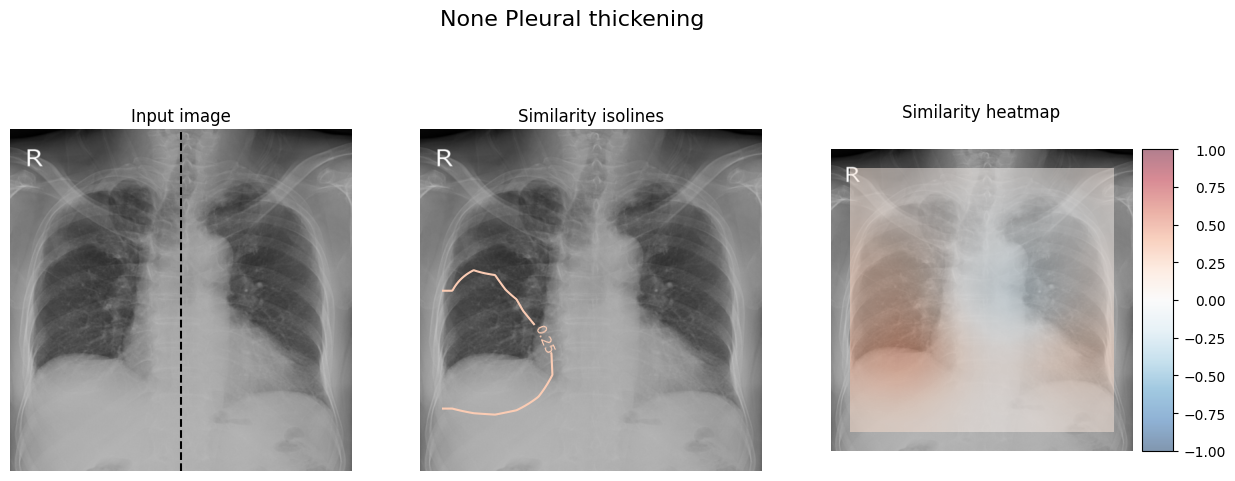

In [5]:
overall = "57a1a6b02398e336508aa57ecf962e74,Pleural thickening,"
vindr_image_id = overall.split(",")[0] if len(overall) > 0 else "40497da14aafc428210b623fc8445288"
vindr_dir_test_path = Path('/vol/biodata/data/chest_xray/VinDr-CXR/1.0.0_png_512/raw/test/')
vindr_image_path = vindr_dir_test_path / f'{vindr_image_id}.png'
phrase = overall.split(",")[1] if len(overall) > 0 else "Aortic enlargement"

plot_phrase_grounding(vindr_image_path,phrase)

## Threshold determination

Trying to figure out what is a good threshold for image text reasoning based tasks (i.e. at what point can I consider a pathology or a phrase to be present in the image)


In [7]:
threshold = 0.2
top_n = 25

def get_top_values(similarity_map):
    top_values = []
    for i in range(similarity_map.shape[0]):
        for j in range(similarity_map.shape[1]):
            if similarity_map[i, j] > threshold:
                top_values.append((i, j, similarity_map[i, j]))

    top_values = sorted(top_values, key = lambda x: x[2], reverse = True)
    return top_values[:top_n]
    

In [24]:
from pathlib import Path 

test_pathology_left_or_right = Path("/vol/biomedic3/bglocker/ugproj2324/nns20/datasets/VinDr-CXR/image_text_reasoning_datasets/test_pathology_left_or_right")
vindr_png_path = Path('/vol/biodata/data/chest_xray/VinDr-CXR/1.0.0_png_512/raw/test')

top_value_average = 0
top_5_value_average = 0
count = 0
zero_count = 0

with open(test_pathology_left_or_right) as f:

    for line in f.readlines():
        image_id, text_prompt, _ = line.strip().split(",")
        image_path = vindr_png_path / f"{image_id}.png"
        # similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        # image_path=image_path,
        # query_text=text_prompt,
        # interpolation="bilinear",
        # )
        similarity_map = image_text_inference.get_similarity_map_from_raw_data(
        image_path=image_path,
        query_text=text_prompt,
        interpolation="bilinear",
        )

        # go through all the values in the similarity map and print out the top 5 values
        top_values = get_top_values(similarity_map)

        if len(top_values) == 0:
            zero_count += 1
            continue
        top_value_average += top_values[0][2]
        top_5_value_average += sum([x[2] for x in top_values[:5]])
        count += 1
        # bboxes = [tuple(map(float, box.split(","))) for box in bboxes.split(";")]
        # plot_phrase_grounding

top_value_average /= count
top_5_value_average /= (count*5)

print(f"{top_value_average=}")
print(f"{top_5_value_average=}")
print(f"{zero_count=}")
print(f"{count=}")


top_value_average=0.3559772091989896
top_5_value_average=0.3557334352675844
zero_count=70
count=2038


: 

## Evaluate latent perfomance on CheXbench task


start by looking at which of the statements has a higher activation (statements contain location descriptor and pathology already)

*Do this without size related questions!*

In [18]:
openi_dataset_path = Path('/vol/biodata/data/chest_xray/OpenI/NLMCXR_png')
image_text_reasoning_gt = Path('/vol/biomedic3/bglocker/ugproj2324/nns20/datasets/CheXbench/image_text_reasoning_task')

def calculate_mean(similarity_map_top_values):
    if len(similarity_map_top_values) == 0:
        return 0
    return sum([x[2] for x in similarity_map_top_values]) / len(similarity_map_top_values)

repeats = 3
for _ in range(repeats):
    total_left_vs_right = 0
    total_mild_vs_severe = 0
    total_upper_vs_lower = 0

    correct_left_vs_right = 0
    correct_mild_vs_severe = 0
    correct_upper_vs_lower = 0

    with open(image_text_reasoning_gt) as file:
        file.readline() # skip the header
        # shuffle the remaining lines
        lines = file.readlines()
        random.shuffle(lines)
        for index, line in enumerate(lines):
            components = line.strip().split(",")
            image_id = components[2]
            question = components[3]
            correct_option = components[4]
            option_0 = components[5]
            option_1 = components[6]

            image_path = openi_dataset_path / f"{image_id}"

            similarity_map_option_0 = image_text_inference.get_similarity_map_from_raw_data(
                image_path=image_path,
                query_text=option_0,
                interpolation="bilinear",
            )

            similarity_map_option_1 = image_text_inference.get_similarity_map_from_raw_data(
                image_path=image_path,
                query_text=option_1,
                interpolation="bilinear",
            )

            top_values_option_0 = calculate_mean(get_top_values(similarity_map_option_0))
            top_values_option_1 = calculate_mean(get_top_values(similarity_map_option_1))

            predicted = 0 if top_values_option_0 > top_values_option_1 else 1

            correct_manual_check = False
            if predicted == int(correct_option):
                correct_manual_check = True

            if ("left" in option_0 and "right" in option_1) or ("right" in option_0 and "left" in option_1):
                total_left_vs_right += 1
                correct_left_vs_right = correct_left_vs_right + 1 if correct_manual_check else correct_left_vs_right

            elif ("mild" in option_0 and "severe" in option_1) or ("severe" in option_0 and "mild" in option_1):
                total_mild_vs_severe += 1
                correct_mild_vs_severe = correct_mild_vs_severe + 1 if correct_manual_check else correct_mild_vs_severe
            
            else:
                total_upper_vs_lower += 1
                correct_upper_vs_lower = correct_upper_vs_lower + 1 if correct_manual_check else correct_upper_vs_lower
            
    print(f"Left vs Right: {correct_left_vs_right/total_left_vs_right:.2f}")
    print(f"Mild vs Severe: {correct_mild_vs_severe/total_mild_vs_severe:.2f}")
    print(f"Upper vs Lower: {correct_upper_vs_lower/total_upper_vs_lower:.2f}")

    print(f"Overall: {(correct_left_vs_right + correct_mild_vs_severe + correct_upper_vs_lower)/(total_left_vs_right + total_mild_vs_severe + total_upper_vs_lower):.2f}")


Left vs Right: 0.57
Mild vs Severe: 0.76
Upper vs Lower: 0.72
Overall: 0.61
Left vs Right: 0.57
Mild vs Severe: 0.76
Upper vs Lower: 0.72
Overall: 0.61
Left vs Right: 0.57
Mild vs Severe: 0.76
Upper vs Lower: 0.72
Overall: 0.61


###  Now only consider the phrases actually detected (i.e. non zero activation)

#### Of those it does detect what is the accuracy

In [9]:
openi_dataset_path = Path('/vol/biodata/data/chest_xray/OpenI/NLMCXR_png')
image_text_reasoning_gt = Path('/vol/biomedic3/bglocker/ugproj2324/nns20/datasets/CheXbench/image_text_reasoning_task')

def calculate_mean(similarity_map_top_values):
    if len(similarity_map_top_values) == 0:
        return 0
    return sum([x[2] for x in similarity_map_top_values]) / len(similarity_map_top_values)

repeats = 1
for _ in range(repeats):
    total_left_vs_right = 0
    detected_left_vs_right = 0

    total_detected_0_1_difference = 0
    total_detected_0_2_difference = 0

    correct_left_vs_right = 0
    correct_left_vs_right_0_1_difference = 0
    correct_left_vs_right_0_2_difference = 0

    with open(image_text_reasoning_gt) as file:
        file.readline() # skip the header
        # shuffle the remaining lines
        lines = file.readlines()
        random.shuffle(lines)
        for index, line in enumerate(lines):
            components = line.strip().split(",")
            image_id = components[2]
            question = components[3]
            correct_option = components[4]
            option_0 = components[5]
            option_1 = components[6]

            image_path = openi_dataset_path / f"{image_id}"

            similarity_map_option_0 = image_text_inference.get_similarity_map_from_raw_data(
                image_path=image_path,
                query_text=option_0,
                interpolation="bilinear",
            )

            similarity_map_option_1 = image_text_inference.get_similarity_map_from_raw_data(
                image_path=image_path,
                query_text=option_1,
                interpolation="bilinear",
            )

            top_values_option_0 = calculate_mean(get_top_values(similarity_map_option_0))
            top_values_option_1 = calculate_mean(get_top_values(similarity_map_option_1))
            activation_difference = abs(top_values_option_0-top_values_option_1)

            if ("left" in option_0 and "right" in option_1) or ("right" in option_0 and "left" in option_1):
                total_left_vs_right += 1

                if (top_values_option_0 + top_values_option_1) > 0:
                    detected_left_vs_right += 1
            
                    print(f"{top_values_option_0=}")
                    print(f"{top_values_option_1=}")
                    print(f"Difference in top values: {abs(top_values_option_0-top_values_option_1)} \n")

                    predicted = 0 if top_values_option_0 > top_values_option_1 else 1

                    correct_manual_check = False
                    if predicted == int(correct_option) :
                        correct_manual_check = True

                    correct_left_vs_right += 1 if correct_manual_check else 0

                    if activation_difference > 0.1:
                        total_detected_0_1_difference += 1 
                        correct_left_vs_right_0_1_difference += 1 if correct_manual_check else 0

                    if activation_difference > 0.2:
                        total_detected_0_2_difference += 1 
                        correct_left_vs_right_0_2_difference += 1 if correct_manual_check else 0
                    

    print(f"Correct detected Left vs Right over Total: {correct_left_vs_right/total_left_vs_right:.2f}")
    print(f"\nRest of datapoints are only over detected:")
    print(f"Correct detected Left vs Right over Detected: {correct_left_vs_right/detected_left_vs_right:.2f}")
    print(f"Correct detected Left vs Right with > 0.1 activation difference: {correct_left_vs_right_0_1_difference/total_detected_0_1_difference:.2f}")
    print(f"Correct detected Left vs Right with > 0.2 activation difference: {correct_left_vs_right_0_2_difference/total_detected_0_2_difference:.2f}")

top_values_option_0=0.2897135901451111
top_values_option_1=0.3610154068470001
Difference in top values: 0.07130181670188901 

top_values_option_0=0.3038837480545044
top_values_option_1=0.2958931124210358
Difference in top values: 0.007990635633468635 

top_values_option_0=0
top_values_option_1=0.5066138815879822
Difference in top values: 0.5066138815879822 

top_values_option_0=0.22532077729701996
top_values_option_1=0
Difference in top values: 0.22532077729701996 

top_values_option_0=0.3102351927757263
top_values_option_1=0.26157657742500307
Difference in top values: 0.048658615350723244 

top_values_option_0=0.30926461338996886
top_values_option_1=0.36820440530776977
Difference in top values: 0.05893979191780091 

top_values_option_0=0.46446370720863345
top_values_option_1=0.5027191853523254
Difference in top values: 0.03825547814369196 

top_values_option_0=0.31359814524650576
top_values_option_1=0.3579471433162689
Difference in top values: 0.04434899806976317 

top_values_option_0

#### Now see how performance varies if we assume not a binary task of localisation 

#### Now assess whether we can localise based only on the pathology description

Just trying to figure out how to best infer location

= easiest option just tag left/ right before pathology and see if either phrase has a mean activation over a threshold (i.e. 0.25 or 0.35), perhaps pass the activation (i.e. location uncertainty) to language model to pass to user

In [28]:
openi_dataset_path = Path('/vol/biodata/data/chest_xray/OpenI/NLMCXR_png')
image_text_reasoning_gt = Path('/vol/biomedic3/bglocker/ugproj2324/nns20/datasets/CheXbench/image_text_reasoning_task')


words_to_remove = {"left","right","small","large","upper","lower","lobe"}

correct_manual_check = 0
total_left_vs_right = 0

repeats = 1

for _ in range(repeats):
    correct_manual_check = 0
    total_left_vs_right = 0
    with open(image_text_reasoning_gt) as file:
        file.readline() # skip the header
        for index, line in enumerate(file.readlines()):
            
            components = line.strip().split(",")
            image_id = components[2]
            correct_option = components[4]
            option_0 = components[5]
            option_1 = components[6]

            correct_written_option = option_0 if correct_option == 0 else option_1

            print(f"{correct_written_option}")

            gt = option_0 if correct_option == 0 else option_1

            if not (("left" in option_0 and "right" in option_1) or ("right" in option_0 and "left" in option_1)):
                continue

            phrase = " ".join([word for word in option_0.split() if word not in words_to_remove])
            # print(phrase)

            image_path = openi_dataset_path / f"{image_id}"

            similarity_map = image_text_inference.get_similarity_map_from_raw_data(
                image_path=image_path,
                query_text=phrase,
                interpolation="bilinear",
            )

            top_activations = get_top_values(similarity_map)
            mean_activation = sum([x[2] for x in top_activations])/top_n
            mean_x_coordinate = sum([x[0] for x in top_activations])/top_n
            unique_top_x_coordinates = set([x[0] for x in top_activations])

            print(f"{mean_activation=}")
            print(f"{unique_top_x_coordinates}")

            image = load_image(image_path).convert("RGB")
            centre = image.size[0] / 2

            prediction = "right" if mean_x_coordinate < centre else "left"
            print(f"{prediction=}")

            if len(unique_top_x_coordinates) > 0:
                total_left_vs_right += 1
                if prediction in gt:
                    correct_manual_check += 1
                    # print("Above ^ is correct\n")

            print("\n")

            

    print(total_left_vs_right)              
    print(f"Left vs Right: {correct_manual_check/total_left_vs_right:.2f}")

elevated left diaphragm
mean_activation=0.6074305534362793
{270, 271, 272, 273, 274, 275, 276, 277}
prediction='left'


surgical instruments in the left lung
mean_activation=0.0
set()
prediction='right'


right base pulmonary atelectasis
mean_activation=0.49557090759277345
{303}
prediction='left'


elevated left diaphragm
mean_activation=0.0
set()
prediction='right'


left base pulmonary atelectasis
mean_activation=0.2885274064540863
{368, 367}
prediction='left'


surgical instruments in the right lung
mean_activation=0.2536977732181549
{278, 279}
prediction='left'


elevated left diaphragm
mean_activation=0.33145364284515383
{274, 275, 276, 277, 278, 279, 280, 281, 282}
prediction='left'


left pleural effusion
mean_activation=0.39304530501365664
{293, 294, 295, 296, 297}
prediction='left'


right lung opacity
mean_activation=0.22680752456188202
{229, 230, 231, 232, 233, 234}
prediction='right'


surgical instruments in the left lung
mean_activation=0.0
set()
prediction='right'


left

## VINDR Experiments

In [ ]:
vindr_pathology_path = Path("/vol/biomedic3/bglocker/ugproj2324/nns20/datasets/VinDr-CXR/image_text_reasoning_datasets/test_pathology_left_or_right")